# NLP_Cyberbullying_Detection

In [8]:
from gettext import install
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

%matplotlib inline

import re
import string

from wordcloud import WordCloud

from textblob import TextBlob


import nltk
from nltk.corpus import wordnet,stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from gensim.models import word2vec

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline

from keras.preprocessing.text import Tokenizer
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense

import transformers
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TextClassificationPipeline)

import joblib

### Import Data

In [9]:
data = pd.read_csv("Datasets//twitter_parsed_dataset.csv").drop(columns=['index','id'])
data

,Text,Annotation,oh_label
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0
4,#mkr No No No No No No,none,0.0
...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",none,0.0
16847,#MKR 'pretty good dishes we're happy with' - O...,none,0.0
16848,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0


In [10]:
data['Text'].sample(1).values[0]

'I wish they went to death row instead of sudden death #Mkr'

<AxesSubplot:>

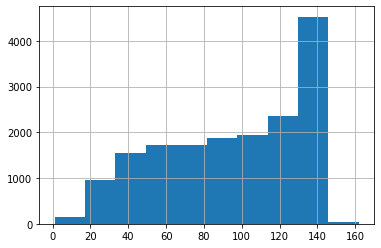

In [11]:
data['Text'].str.len().hist()

([<matplotlib.axis.XTick at 0x26f5e501240>,
 [Text(0, 0, '+ve'), Text(1, 0, '-ve')])

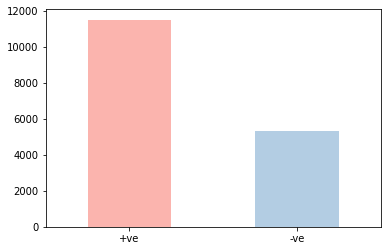

In [12]:
data['oh_label'].value_counts().plot(kind='bar',color=sns.color_palette('Pastel1'))
plt.xticks([0,1],['+ve','-ve'],rotation=0)

### NLP_EDA & Preprocessing

In [13]:
data.isna().sum()

Text          1
Annotation    3
oh_label      3
dtype: int64

In [14]:
data.isna().sum()[data.isna().sum() != 0]

Text          1
Annotation    3
oh_label      3
dtype: int64

In [15]:
impute_cols = [x for x in data.isna().sum()[data.isna().sum() != 0].index.to_list()]
for fet in impute_cols:
    data[fet].fillna(data[fet].mode()[0],inplace=True)

In [16]:
data.isna().sum()

Text          0
Annotation    0
oh_label      0
dtype: int64

#### Text character-wise cleaning

In [17]:
def change_case_lower(text):
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    
    return sample

def remove_url(text):
    sample = text
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls 
    
    return sample

def remove_html(text):
    sample = text
    comp = re.compile(r'<.*?>')
    sample = re.sub(comp, '', sample)
    
    return sample

def remove_punctuations(text):
    sample = text
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('[%s]' % re.escape(string.punctuation), '', sample) #punctuations
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    
    return sample

only_english = set(nltk.corpus.words.words())
def remove_special_characters(text):
    sample = text
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = ' '.join([w for w in nltk.wordpunct_tokenize(sample) if w.lower() in only_english or not w.isalpha()]) #doesn't remove indian languages
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    sample = " ".join([x.strip() for x in sample.split()])
    
    return sample

def remove_hashtags_total(text):
    sample = text
    sample = re.sub('#', ' ', sample) # 
    
    return sample

def remove_hashtags_only(text):
    sample = text
    sample = ' '.join([x for x in s.split() if not x.startswith('#')])
    
    return sample

def remove_emojis(text):
    sample = text
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    return sample

In [18]:
s= "RT @The_Loki_Jotunn: </b> 😅😄 @MT8_9 Literally on this site #Today todayðŸ˜‚ http://t.co/YhUzMng7Gc"
s

'RT @The_Loki_Jotunn: </b> 😅😄 @MT8_9 Literally on this site #Today todayðŸ˜‚ http://t.co/YhUzMng7Gc'

In [19]:
change_case_lower(s)

'rt @the_loki_jotunn: </b> 😅😄 @mt8_9 literally on this site #today todayðÿ˜‚ http://t.co/yhuzmng7gc'

In [20]:
remove_url(s)

'RT @The_Loki_Jotunn: </b> 😅😄 @MT8_9 Literally on this site #Today todayðŸ˜‚ '

In [21]:
remove_html(s)

'RT @The_Loki_Jotunn:  😅😄 @MT8_9 Literally on this site #Today todayðŸ˜‚ http://t.co/YhUzMng7Gc'

In [22]:
remove_punctuations(s)

'RT TheLokiJotunn b 😅😄 MT89 Literally on this site Today todayðŸ˜‚ httptcoYhUzMng7Gc'

In [23]:
remove_special_characters(s)

'The_Loki_Jotunn b MT8_9 Literally on this site Today t YhUzMng7Gc'

In [24]:
remove_hashtags_total(s)

'RT @The_Loki_Jotunn: </b> 😅😄 @MT8_9 Literally on this site  Today todayðŸ˜‚ http://t.co/YhUzMng7Gc'

In [25]:
remove_hashtags_only(s)

'RT @The_Loki_Jotunn: </b> 😅😄 @MT8_9 Literally on this site todayðŸ˜‚ http://t.co/YhUzMng7Gc'

In [26]:
remove_emojis(s)

'RT @The_Loki_Jotunn: </b>  @MT8_9 Literally on this site #Today todayðŸ˜‚ http://t.co/YhUzMng7Gc'

**COMPILING EVERYTHNG WITH IN-ORDER CONTEXT**

In [27]:
only_english =  set(nltk.corpus.words.words())
only_english

{'ratchel',
 'protopragmatic',
 'concernment',
 'metaprescutum',
 'Spirosoma',
 'ungainful',
 'scholarless',
 'churchly',
 'kitabis',
 'naturize',
 'joyancy',
 'noncomplying',
 'preadministrative',
 'tachinid',
 'blest',
 'ecad',
 'saltpetrous',
 'Quakerlike',
 'Roxbury',
 'apocalypse',
 'tetrapterous',
 'homestretch',
 'whisperer',
 'curtal',
 'outsetting',
 'paddockride',
 'caudolateral',
 'chronogenesis',
 'guardo',
 'vauntiness',
 'bristliness',
 'fogey',
 'indisciplinable',
 'battarism',
 'parados',
 'blepharoplastic',
 'biologist',
 'loo',
 'thermoperiodicity',
 'deceptitious',
 'arthropomatous',
 'unembezzled',
 'diadermic',
 'phosphotungstic',
 'hyperfine',
 'nonepic',
 'Molluginaceae',
 'nonaesthetic',
 'overstitch',
 'ophthalmoplegia',
 'philosophicalness',
 'churlish',
 'homogenization',
 'piperidge',
 'reichstaler',
 'schooldom',
 'underofficer',
 'divestiture',
 'wounder',
 'putrescible',
 'bokard',
 'martext',
 'jaggery',
 'underived',
 'privileged',
 'desulphurate',
 'me

In [28]:

def clean_text(text):
    sample = change_case_lower(text)
    sample = remove_url(sample)
    sample = remove_html(sample)
    sample = remove_punctuations(sample)
    sample = remove_special_characters(sample)
    sample = remove_hashtags_total(sample)
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    return sample

In [29]:
data['cleaned_text'] = data['Text'].apply(lambda x:clean_text(x))
data

,Text,Annotation,oh_label,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,i read them in change in meaning the history o...
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,shreyabafna3 now you claim that people who tri...
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,call me but when i go to an auto place id rath...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,g0ssipsquirrelx wrong the example of and the e...
4,#mkr No No No No No No,none,0.0,no no no no no no
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",none,0.0,feeling so sorry for the they should be safe a...
16847,#MKR 'pretty good dishes we're happy with' - O...,none,0.0,pretty good were happy with well never eating ...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0,lemon we please go just one season of without ...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0,you are too stupid to talk to blocked


In [30]:
data['cleaned_text'].sample(1).values[0]

'whole flathead'

**TOKENIZATION,STOPWORD,POS,STEMMING,LEMMATIZATION**

In [31]:
# Caching stopwords outside for better speed
stops = set(stopwords.words('english'))
def remove_stop_words(text, cores = 2):
    
    sample = text
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    return sample


# get POS Tag for word
def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

# Lemmatizing the data
# Steps to convert : Document -> Sentences -> Tokens -> POS -> Lemmas
lemmatizer = WordNetLemmatizer()
def lemma_clean_text(text, cores = 1):
 
    sample = text
    sample = sample.split()
    sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
    sample = ' '.join(sample)
    
    return sample


# Stemming the data
ps = PorterStemmer()
def stem_clean_text(text):
 
    sample = text
    sample = sample.split()
    sample = [ps.stem(word) for word in sample]
    sample = ' '.join(sample)
    
    return sample

def correct_spelling(text):
    
    sample = text
    sample = str(TextBlob(text).correct())
    
    return sample

In [32]:
remove_stop_words(s)

'rt @the_loki_jotunn: </b> 😅😄 @mt8_9 literally site #today todayðÿ˜‚ http://t.co/yhuzmng7gc'

In [33]:
# lemma_clean_text(s, cores = 1)

In [34]:
stem_clean_text(s)

'rt @the_loki_jotunn: </b> 😅😄 @mt8_9 liter on thi site #today todayðÿ˜‚ http://t.co/yhuzmng7gc'

In [35]:
stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()
def correct_text(text, stem=False, lemma=False, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text
    
    sample = text
    
    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    if lemma:
        sample = sample.split()
        sample = [lemmatizer.lemmatize(word) for word in sample]
        sample = ' '.join(sample)
        
    if stem:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)
    
    if spell:
        sample = str(TextBlob(text).correct())
    
    return sample

In [36]:
data['correct_text'] = data['cleaned_text'].apply(lambda x: correct_text(x))
data

,Text,Annotation,oh_label,cleaned_text,correct_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,none,0.0,i read them in change in meaning the history o...,read change meaning history slavery
1,@ShreyaBafna3 Now you idiots claim that people...,none,0.0,shreyabafna3 now you claim that people who tri...,shreyabafna3 claim people tried stop becoming ...
2,"RT @Mooseoftorment Call me sexist, but when I ...",sexism,1.0,call me but when i go to an auto place id rath...,call go auto place id rather talk guy
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",racism,1.0,g0ssipsquirrelx wrong the example of and the e...,g0ssipsquirrelx wrong example exactly
4,#mkr No No No No No No,none,0.0,no no no no no no,
...,...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",none,0.0,feeling so sorry for the they should be safe a...,feeling sorry safe kat going home
16847,#MKR 'pretty good dishes we're happy with' - O...,none,0.0,pretty good were happy with well never eating ...,pretty good happy well never eating place
16848,RT @colonelkickhead: Deconstructed lemon tart!...,none,0.0,lemon we please go just one season of without ...,lemon please go one season without someone cal...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,none,0.0,you are too stupid to talk to blocked,stupid talk blocked


In [37]:
l1 = 'no no no no no no'
l2 = "I am not racist"



In [38]:
l1,l2

('no no no no no no', 'I am not racist')

In [39]:
l3 = clean_text(l1)
l3

'no no no no no no'

In [40]:
l4 = clean_text(l2)
l4

'i am not racist'

In [41]:
correct_text(l3)

''

In [42]:
correct_text(l4)

'racist'

In [43]:
[stops]

[{'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'am',
  'an',
  'and',
  'any',
  'are',
  'aren',
  "aren't",
  'as',
  'at',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'but',
  'by',
  'can',
  'couldn',
  "couldn't",
  'd',
  'did',
  'didn',
  "didn't",
  'do',
  'does',
  'doesn',
  "doesn't",
  'doing',
  'don',
  "don't",
  'down',
  'during',
  'each',
  'few',
  'for',
  'from',
  'further',
  'had',
  'hadn',
  "hadn't",
  'has',
  'hasn',
  "hasn't",
  'have',
  'haven',
  "haven't",
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'his',
  'how',
  'i',
  'if',
  'in',
  'into',
  'is',
  'isn',
  "isn't",
  'it',
  "it's",
  'its',
  'itself',
  'just',
  'll',
  'm',
  'ma',
  'me',
  'mightn',
  "mightn't",
  'more',
  'most',
  'mustn',
  "mustn't",
  'my',
  'myself',
  'needn',
  "needn't",
  'no',
  'nor',
  'not',
  'now',
  'o',
  'of',
  'off',
 

#### Feature Extraction

**WORDCOUNT**

In [44]:
data['word_count'] = data['correct_text'].apply(lambda x: len(str(x).split(" ")))
data[['correct_text','word_count']]

,correct_text,word_count
0,read change meaning history slavery,5
1,shreyabafna3 claim people tried stop becoming ...,11
2,call go auto place id rather talk guy,8
3,g0ssipsquirrelx wrong example exactly,4
4,,1
...,...,...
16846,feeling sorry safe kat going home,6
16847,pretty good happy well never eating place,7
16848,lemon please go one season without someone cal...,9
16849,stupid talk blocked,3


<AxesSubplot:>

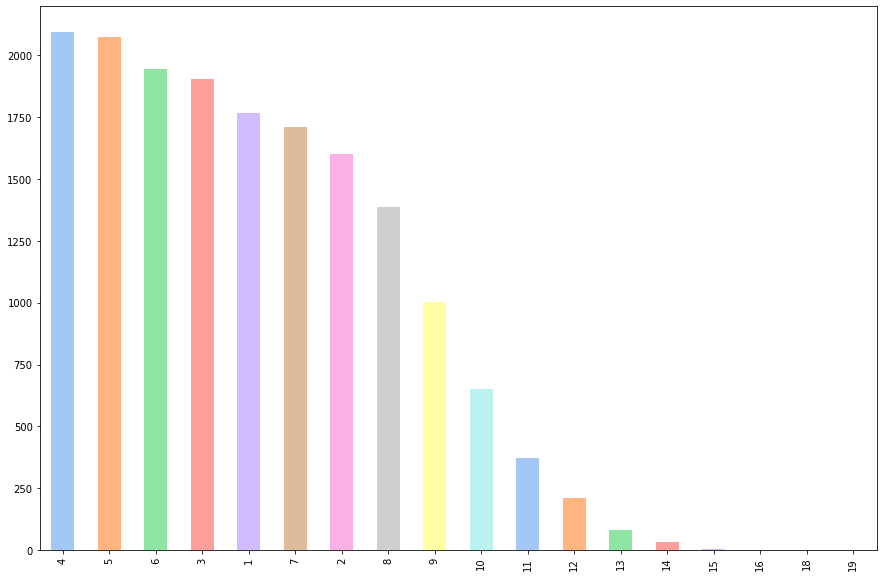

In [45]:
plt.figure(figsize=(15,10))
data['word_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

**CHARACTER_COUNT**

In [46]:
data['char_count'] = data['correct_text'].str.len() ## this also includes spaces
data[['correct_text','char_count']]

,correct_text,char_count
0,read change meaning history slavery,35
1,shreyabafna3 claim people tried stop becoming ...,81
2,call go auto place id rather talk guy,37
3,g0ssipsquirrelx wrong example exactly,37
4,,0
...,...,...
16846,feeling sorry safe kat going home,33
16847,pretty good happy well never eating place,41
16848,lemon please go one season without someone cal...,60
16849,stupid talk blocked,19


<AxesSubplot:>

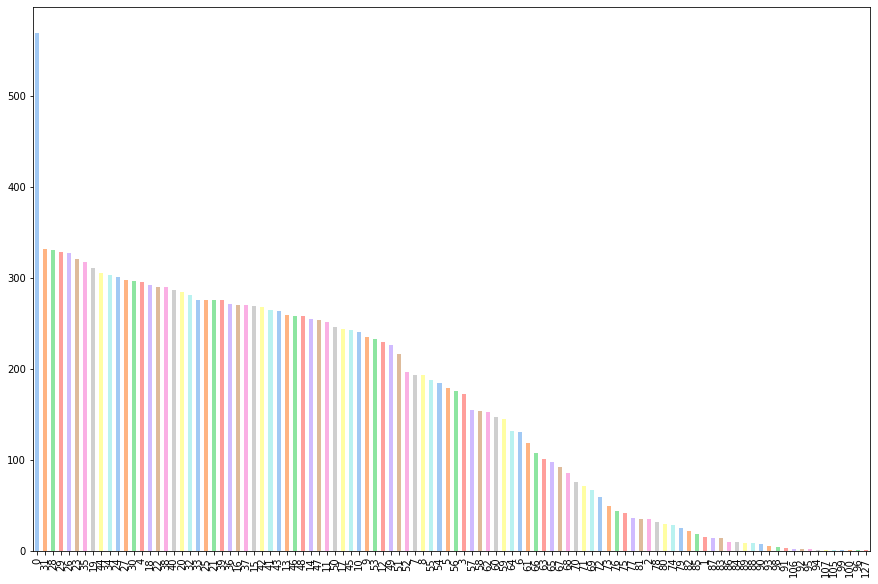

In [47]:
plt.figure(figsize=(15,10))
data['char_count'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

**AVERAGE_WORD_COUNT**

In [48]:
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/(len(words)+0.000001))

data['avg_word'] = data['correct_text'].apply(lambda x: avg_word(x)).round(1)
data[['correct_text','avg_word']].head()

,correct_text,avg_word
0,read change meaning history slavery,6.2
1,shreyabafna3 claim people tried stop becoming ...,6.5
2,call go auto place id rather talk guy,3.7
3,g0ssipsquirrelx wrong example exactly,8.5
4,,0.0


<AxesSubplot:>

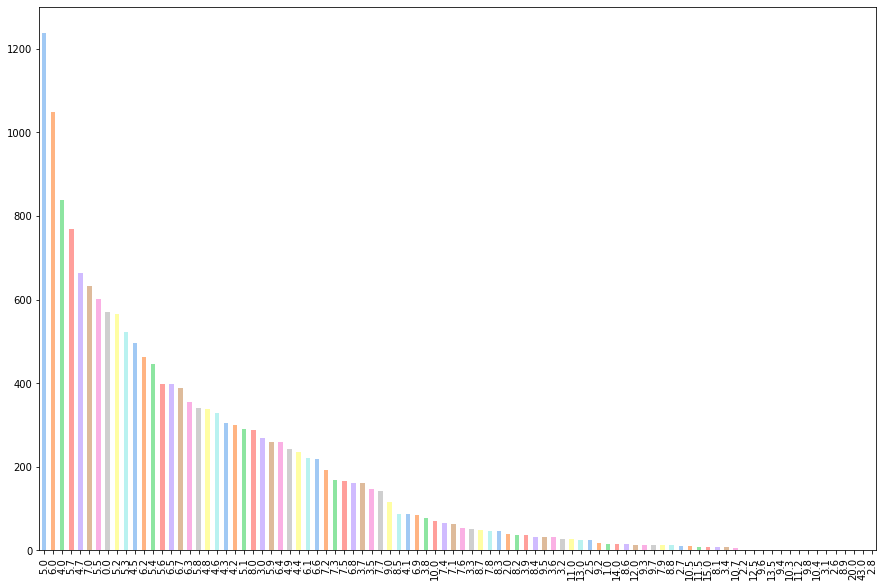

In [49]:
plt.figure(figsize=(15,10))
data['avg_word'].value_counts().plot(kind='bar', color=sns.color_palette('pastel'))

In [50]:
final_data = data[['correct_text', 'word_count', 'char_count', 'avg_word', 'oh_label']]
final_data

,correct_text,word_count,char_count,avg_word,oh_label
0,read change meaning history slavery,5,35,6.2,0.0
1,shreyabafna3 claim people tried stop becoming ...,11,81,6.5,0.0
2,call go auto place id rather talk guy,8,37,3.7,1.0
3,g0ssipsquirrelx wrong example exactly,4,37,8.5,1.0
4,,1,0,0.0,0.0
...,...,...,...,...,...
16846,feeling sorry safe kat going home,6,33,4.7,0.0
16847,pretty good happy well never eating place,7,41,5.0,0.0
16848,lemon please go one season without someone cal...,9,60,5.8,0.0
16849,stupid talk blocked,3,19,5.7,0.0


#### Word Cloud

**POSITIVE_TWEET**

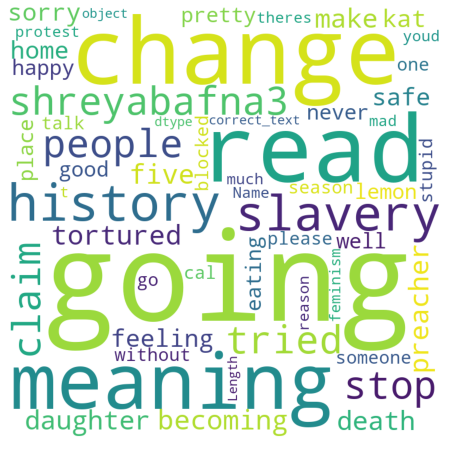

In [51]:
g = str(data[data['oh_label']==0]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='white', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

**NEGATIVE_TWEET**

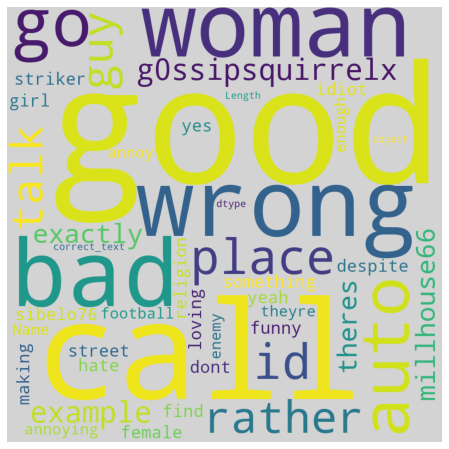

In [52]:
g = str(data[data['oh_label']==1]['correct_text'])

wordcloud = WordCloud(width = 800, height = 800, background_color ='lightgrey', min_font_size = 10).generate(g)
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
#plt.tight_layout(pad = 0) 
  
plt.show()

### Corpus Assembly & Modeling

#### Word Embeddings

In [53]:
X = final_data.drop(columns=['oh_label'])
y = final_data['oh_label']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [54]:
X_train,y_train

(                                            correct_text  word_count  \
 5157       able afford another monitor sadly tech budget           7   
 16382                  safe strategically marking id put           5   
 362                                 end last nights show           4   
 9322                                    think dont human           3   
 15520                             know plenty people bye           4   
 ...                                                  ...         ...   
 2623            like torture defend doesnt seem convince           6   
 12363  turned woman normal human function like eating...          13   
 5695                                                               1   
 8006    might get shut legal name name known anyone know           9   
 13151               arennie44 course slavery rape female           5   
 
        char_count  avg_word  
 5157           45       5.6  
 16382          33       5.8  
 362            20       4.2 

In [55]:

X_test,y_test

(                                            correct_text  word_count  \
 3234                                             picture           1   
 16252              didnt serve cold pizza breakfast item           6   
 5145                   one ever book men stop like human           7   
 4627             stoning death become common state today           6   
 11057                             know kat remind remind           4   
 ...                                                  ...         ...   
 5413                                              iqy007           1   
 5229                               stupid dont know find           4   
 1707                                      full blown try           3   
 7423                       well didnt take long good job           6   
 4480   photo shoot thing tomorrow guess need clean ap...          14   
 
        char_count  avg_word  
 3234            7       7.0  
 16252          37       5.3  
 5145           33       3.9 

In [56]:
X_train.isna().sum()

correct_text    0
word_count      0
char_count      0
avg_word        0
dtype: int64

In [57]:
z_train = X_train.drop(columns=['correct_text'])
z_test = X_test.drop(columns=['correct_text'])

In [58]:
z_train,z_test

(       word_count  char_count  avg_word
 5157            7          45       5.6
 16382           5          33       5.8
 362             4          20       4.2
 9322            3          16       4.7
 15520           4          22       4.7
 ...           ...         ...       ...
 2623            6          40       5.8
 12363          13          87       5.8
 5695            1           0       0.0
 8006            9          48       4.4
 13151           5          36       6.4
 
 [11290 rows x 3 columns],
        word_count  char_count  avg_word
 3234            1           7       7.0
 16252           6          37       5.3
 5145            7          33       3.9
 4627            6          39       5.7
 11057           4          22       4.7
 ...           ...         ...       ...
 5413            1           6       6.0
 5229            4          21       4.5
 1707            3          14       4.0
 7423            6          29       4.0
 4480           14          

In [59]:
X_train = X_train['correct_text']
X_test = X_test['correct_text']

In [60]:
X_train,X_train.shape

(5157         able afford another monitor sadly tech budget
 16382                    safe strategically marking id put
 362                                   end last nights show
 9322                                      think dont human
 15520                               know plenty people bye
                                ...                        
 2623              like torture defend doesnt seem convince
 12363    turned woman normal human function like eating...
 5695                                                      
 8006      might get shut legal name name known anyone know
 13151                 arennie44 course slavery rape female
 Name: correct_text, Length: 11290, dtype: object,
 (11290,))

In [61]:
X_test,X_test.shape

(3234                                               picture
 16252                didnt serve cold pizza breakfast item
 5145                     one ever book men stop like human
 4627               stoning death become common state today
 11057                               know kat remind remind
                                ...                        
 5413                                                iqy007
 5229                                 stupid dont know find
 1707                                        full blown try
 7423                         well didnt take long good job
 4480     photo shoot thing tomorrow guess need clean ap...
 Name: correct_text, Length: 5561, dtype: object,
 (5561,))

In [62]:
X_train.fillna(" ", axis=0, inplace=True)
X_test.fillna(" ", axis=0, inplace=True)
y_train.fillna(0.0, inplace=True)
y_test.fillna(1.0, inplace=True)

In [63]:
X_train

5157         able afford another monitor sadly tech budget
16382                    safe strategically marking id put
362                                   end last nights show
9322                                      think dont human
15520                               know plenty people bye
                               ...                        
2623              like torture defend doesnt seem convince
12363    turned woman normal human function like eating...
5695                                                      
8006      might get shut legal name name known anyone know
13151                 arennie44 course slavery rape female
Name: correct_text, Length: 11290, dtype: object

**BAG_OF_WORDS**

In [64]:
bow = CountVectorizer(max_features=500)

In [65]:
X_train_vect = bow.fit_transform(X_train)
X_test_vect = bow.transform(X_test)

In [66]:
X_train_vect.toarray()

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [67]:
x_t1 = pd.DataFrame(X_train_vect.toarray(),columns=bow.get_feature_names())
x_t2 = pd.DataFrame(X_test_vect.toarray(),columns=bow.get_feature_names())

c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [68]:
x_t1

,98halima,able,absolutely,abuse,account,actually,ago,agree,air,almost,...,would,wouldnt,wow,wrong,yeah,year,yes,yet,youve,zero
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
x_train = pd.concat([x_t1, z_train.reset_index(drop=True)], axis=1)
x_test = pd.concat([x_t2, z_test.reset_index(drop=True)], axis=1)

In [70]:
x_train

,98halima,able,absolutely,abuse,account,actually,ago,agree,air,almost,...,wrong,yeah,year,yes,yet,youve,zero,word_count,char_count,avg_word
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,45,5.6
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,5,33,5.8
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,20,4.2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,16,4.7
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,4,22,4.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11285,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,40,5.8
11286,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,13,87,5.8
11287,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.0
11288,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,48,4.4


In [71]:
clf = MultinomialNB()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

In [72]:
print("logloss: %0.3f " % log_loss(y_test.values, pred))

logloss: 8.416 


**WORD2VEC**

In [73]:
class Word_to_Vect():
    '''Function that returns word embedding, if passed list of sentences and size of vector'''
    
    def __init__(self):
        pass
    
    def w2v(self, corpus):
        
        #tokenization and model preparation
        tokenize_sent = [sent.split() for sent in corpus]
        #creating vord2vec for every word in every sentence in corpus
        self.w2v = word2vec.Word2Vec(tokenize_sent, min_count=1)
        
        return self.w2v
    
    def transform(self, X_corpus, size):
        
        array_wordEmbed = []
        for sent in X_corpus:
            vec = np.zeros(size).reshape((1, size))
            count = 0.
            if sent == '':
                a = vec
            else:
                sent = sent.split(' ')
                for word in sent:
                    vec += w2v[word].reshape((1,size))
                    count +=1
            if count !=0:
                vec /= count
            a = vec
            array_wordEmbed.append(a)
        return np.concatenate(tuple(array_wordEmbed))

In [74]:
w2v = Word_to_Vect().w2v(corpus = [sent for sent in X['correct_text']])

In [75]:
w2v.wv.similar_by_vector('wrong')

[('able', 0.9997332692146301),
 ('ever', 0.9997254610061646),
 ('made', 0.9997174739837646),
 ('great', 0.9997064471244812),
 ('woman', 0.9996997714042664),
 ('new', 0.9996993541717529),
 ('get', 0.9996993541717529),
 ('nothing', 0.9996941089630127),
 ('thing', 0.999692976474762),
 ('also', 0.9996903538703918)]

***We can create the document-term matrix by creating a dictionary with `"word": "value"`, using the below function***

In [76]:
X_w2v = pd.DataFrame({word:w2v.wv[word] for sent in X['correct_text'] for word in sent.split()})
X_w2v

,read,change,meaning,history,slavery,shreyabafna3,claim,people,tried,stop,...,reb,lorry,accomplishment,overdramatic,feat,apocalypse,rhoward617,rossbarnes9,msaleh14,pacify
0,-0.271530,-0.138249,-0.067601,-0.147461,-0.193127,0.000616,-0.148423,-0.362482,-0.071230,-0.283401,...,-0.000475,-0.015509,-0.007184,-0.011522,-0.003593,0.002380,-0.011272,-0.008842,-0.009793,-0.006499
1,0.473763,0.237510,0.108014,0.251064,0.294698,0.019048,0.240626,0.592999,0.124212,0.484000,...,0.007406,0.017279,0.018708,-0.006156,0.009120,0.006484,-0.001089,0.000611,0.001771,0.018932
2,0.173599,0.077359,0.033714,0.091559,0.107338,0.012851,0.089738,0.212703,0.048699,0.169204,...,-0.000605,-0.002308,0.006300,0.004503,0.002383,-0.001443,0.002598,0.000351,-0.006262,0.002401
3,-0.022823,-0.009404,-0.005496,-0.004100,-0.001127,-0.002408,-0.006933,-0.021324,0.004069,-0.026046,...,0.000544,0.007110,0.006759,-0.002194,0.004852,-0.002178,-0.002285,-0.004973,-0.005685,0.008324
4,0.055050,0.042268,0.016712,0.024951,0.039908,-0.007800,0.033135,0.082290,0.025040,0.073885,...,0.007502,-0.000684,-0.001445,0.004796,0.010567,-0.007490,-0.004742,-0.002466,-0.008098,0.011283
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.694594,0.339438,0.163612,0.365407,0.452664,0.014870,0.364450,0.854556,0.197692,0.714462,...,0.017145,0.016452,0.013786,0.005784,0.011324,0.004444,0.006646,0.003596,0.009205,0.020735
96,0.356273,0.173006,0.087394,0.176251,0.221108,0.003810,0.175438,0.433721,0.102044,0.359194,...,0.003605,0.010504,0.007235,-0.006804,0.007598,-0.004799,0.004504,0.009345,-0.008779,-0.000840
97,-0.472550,-0.236865,-0.121990,-0.257750,-0.303576,-0.015139,-0.249365,-0.593891,-0.133155,-0.498573,...,-0.003536,-0.007027,-0.010830,-0.013232,-0.004844,-0.008208,-0.008659,-0.002669,-0.009972,-0.013726
98,0.262203,0.132294,0.056981,0.142815,0.165144,-0.003389,0.141366,0.311551,0.079453,0.259381,...,0.009173,0.007106,-0.004174,0.000778,0.010301,0.011631,0.008698,0.002114,0.005781,0.013067


In [77]:
clf = XGBClassifier()
clf.fit(x_train, y_train)
pred = clf.predict(x_test)

In [78]:
print("logloss: %0.3f " % log_loss(y_test.values, pred))

logloss: 8.503 


### Modeling
- ML Algorithms
- DL Neural Network

#### Machine Learning Algorithms :-

In [79]:
rf = RandomForestClassifier(n_estimators=500, bootstrap=True, min_samples_split=5)
rf.fit(x_train, y_train)

RandomForestClassifier(min_samples_split=5, n_estimators=500)

In [80]:
y_pred_ml = rf.predict(x_test)

In [81]:
print("logloss: %0.3f " % log_loss(y_pred_ml, pred))

logloss: 2.565 


#### Deep Learning Neural Network :-

In [82]:
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(50, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    # plot_model(model, to_file='model.png', show_shapes=True)
    return model

model = define_model(x_train.shape[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 50)                25200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 25,251
Trainable params: 25,251
Non-trainable params: 0
_________________________________________________________________


In [83]:
model.fit(np.asarray(x_train), np.asarray(y_train), epochs=50, batch_size=50)

Epoch 1/50
226/226 [==============================] - 0s 871us/step - loss: 0.6515 - accuracy: 0.6803
Epoch 2/50
226/226 [==============================] - 0s 862us/step - loss: 0.5407 - accuracy: 0.7378
Epoch 3/50
226/226 [==============================] - 0s 867us/step - loss: 0.5102 - accuracy: 0.7636
Epoch 4/50
226/226 [==============================] - 0s 893us/step - loss: 0.4964 - accuracy: 0.7683
Epoch 5/50
226/226 [==============================] - 0s 844us/step - loss: 0.4869 - accuracy: 0.7746
Epoch 6/50
226/226 [==============================] - 0s 836us/step - loss: 0.4808 - accuracy: 0.7756
Epoch 7/50
226/226 [==============================] - 0s 836us/step - loss: 0.4759 - accuracy: 0.7814
Epoch 8/50
226/226 [==============================] - 0s 840us/step - loss: 0.4691 - accuracy: 0.7833
Epoch 9/50
226/226 [==============================] - 0s 853us/step - loss: 0.4656 - accuracy: 0.7851
Epoch 10/50
226/226 [==============================] - 0s 889us/step - loss: 0.466

In [84]:
# evaluate
loss, acc = model.evaluate(np.asarray(x_test), np.asarray(y_test))
print('Test Accuracy: %f' % (acc*100))
print('Test Loss: %f' % (loss*100))

174/174 [==============================] - 0s 671us/step - loss: 0.6205 - accuracy: 0.7488
Test Accuracy: 74.878621
Test Loss: 62.045866


In [85]:
y_pred_dl = model.predict(np.asarray(x_test))

174/174 [==============================] - 0s 561us/step


In [86]:
print("logloss: %0.3f " % log_loss(y_test, y_pred_dl.round(), eps=1e-7))

logloss: 4.037 


**Transformer pretrained model from distilBERT**

In [87]:
tokenizer_name = "distilbert-base-uncased"
model_name = "distilbert-base-uncased-finetuned-sst-2-english"

In [88]:
tokenizer = transformers.DistilBertTokenizerFast.from_pretrained(tokenizer_name)
trn = transformers.DistilBertForSequenceClassification.from_pretrained(model_name).cpu()
pipe = TextClassificationPipeline(model=trn, tokenizer=tokenizer, return_all_scores=True)

c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\serialization.py:871: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  obj = cast(Storage, torch._UntypedStorage(nbytes))
c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\pipelines\text_classification.py:89: UserWarning: `return_all_scores` is now deprecated,  if want a similar funcionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [89]:
print(X_test[5561])
pipe([X_test[5561]])

KeyError: 5561